# Traffic sign classifier

## Machine Learning Project: Build a Traffic Sign Classifier

---

This project aims to be a study and a reworking of [this](https://github.com/lfiaschi/udacity-traffic-sign-classifier) notebook.

---

## Step 0: Load the Dataset

TODO dove abbiamo preso le immagini, perché si è deciso di non utilizzare un dataset già elaborato con pickle

In [1]:
import cv2 # resize the images
import numpy as np
import pandas as pd
import os # to work with directories
from random import shuffle # shuffle data
import warnings
warnings.filterwarnings('ignore')

DATASET_DIR = '/datasets/GTSRB/Images/'
ANNOTATION_FILE = './signnames.csv'

IMAGE_SIZE = 32
# LR = 1e-3
# MODEL_NAME = 'trafficsigns--{}--{}.model'.format(LR, "2conv-basic")

Load the csv file with the annotations

In [2]:
signnames = pd.read_csv(ANNOTATION_FILE)
signnames.set_index('ClassId',inplace=True) 
print(signnames[:5])

def get_name_from_label(label):
    """Return the textual name corresponding to the numeric class id
    
    this functions look for a correspondence between the numeric class id 
    and the textual name of the class.
    
    :param label: the numeric class id
    :type label: int
    :returns: the textual name of the class
    
    :Example:

    >>> get_name_from_label(0)
    Speed limit (20km/h)   
    """    
    
    return signnames.loc[label].SignName

                     SignName
ClassId                      
0        Speed limit (20km/h)
1        Speed limit (30km/h)
2        Speed limit (50km/h)
3        Speed limit (60km/h)
4        Speed limit (70km/h)


The images are divided into folders based on their category. The *load_dataset* function create a list of all the images labeled with the name of their folder.

In [3]:
def load_dataset(path):
    """Load a dataset of images given a path
    
    this function look for images on the subfolders of the given path and label 
    them with the name of the folder where the image is stored
    
    :param path: the path where the images divided into folders are stored
    :returns: a numpy array    
    """
    dataset = {}
    dataset['features'] = []
    dataset['labels'] = []
    
    
    for subdir, dirs, files in os.walk(path): # all file on the dataset folder
        for file in files: # one image by one
            
            filename, file_extension = os.path.splitext(file) # extension control
            if file_extension == '.ppm':
                label = os.path.basename(subdir) # obtain the image label (name of the folder)
                imgPath = os.path.join(path, label, file) # the path of the image
                
                # load image with cv2 library
                # img = cv2.imread(imgPath, 0)  
                # img = cv2.resize(cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
                img = cv2.resize(cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB), (IMAGE_SIZE, IMAGE_SIZE))
                label = int(label) # remove the zeros ahead the name of the folder
                
                dataset['features'].append(np.asarray(img))
                dataset['labels'].append(label)
                
                # dataset.append([np.array(img), np.array(str(label))])
                       
    # shuffle(dataset)
    # np.save('dataset.npy', dataset)
    return dataset

---

### Obtain Trainset, Testset and Validset


In [4]:
from sklearn.model_selection import train_test_split

dataset = load_dataset(DATASET_DIR)

X, y = dataset['features'], dataset['labels']
#prende il 70% per il train e il 30% per il test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)


# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of testing examples.
n_valid = len(X_valid)

# What's the shape of an traffic sign image?
# image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

print("Number of testing examples =", n_test)

# print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


#print("dataset cardinality : {}".format(len(dataset)))

#stampa del dataset sotto forma di numpy array. (giusto?)
# print(dataset['labels'][0]) # stampa di una delle foto


Number of training examples = 27446
Number of validation examples = 5882
Number of testing examples = 5881
Number of classes = 43


---

## Step 1: Dataset Summary & Exploration

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

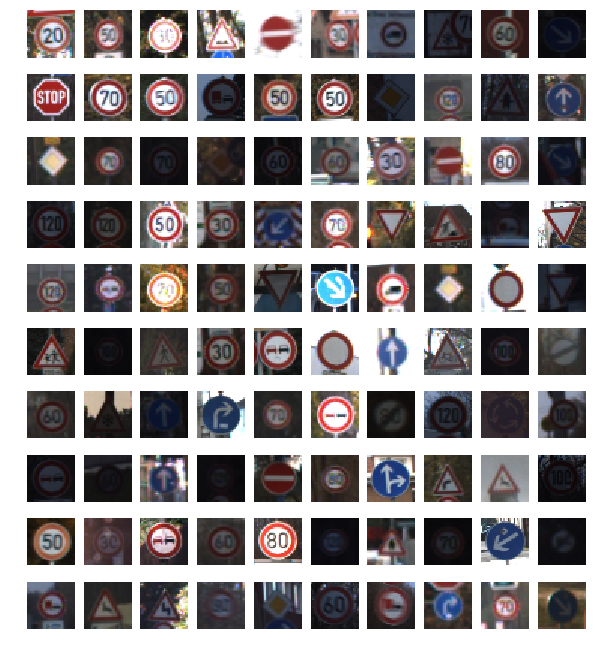

In [6]:
plt.figure(figsize=(10,50))
count = 0
cols = 10
for i in range(100):
    count += 1
    plt.subplot(43, cols, count)
    #plt.imshow(X_train[ii])
    plt.imshow(X_train[i])
    plt.axis('off')

In [7]:
counter = Counter(y_train)

# conta il numero di samples per categoria (min , max , mean)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 638 min 140 max 1589

Most common signs:
'Speed limit (50km/h)'  train samples: 1589
'Speed limit (30km/h)'  train samples: 1533
'Yield'  train samples: 1527
'Priority road'  train samples: 1486
'Keep right'  train samples: 1474
'Speed limit (70km/h)'  train samples: 1373
'No passing for vehicles over 3.5 metric tons'  train samples: 1363
'Speed limit (80km/h)'  train samples: 1316
'No passing'  train samples: 1062
'Road work'  train samples: 1037

Most rare signs:
'Go straight or left'  train samples: 140
'Dangerous curve to the left'  train samples: 144
'Speed limit (20km/h)'  train samples: 150
'Pedestrians'  train samples: 161
'End of all speed and passing limits'  train samples: 166
'End of no passing'  train samples: 168
'End of no passing by vehicles over 3.5 metric tons'  train samples: 178
'Bicycles crossing'  train samples: 185
'Road narrows on the right'  train samples: 201
'Keep left'  train samples: 216


In [8]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label) 

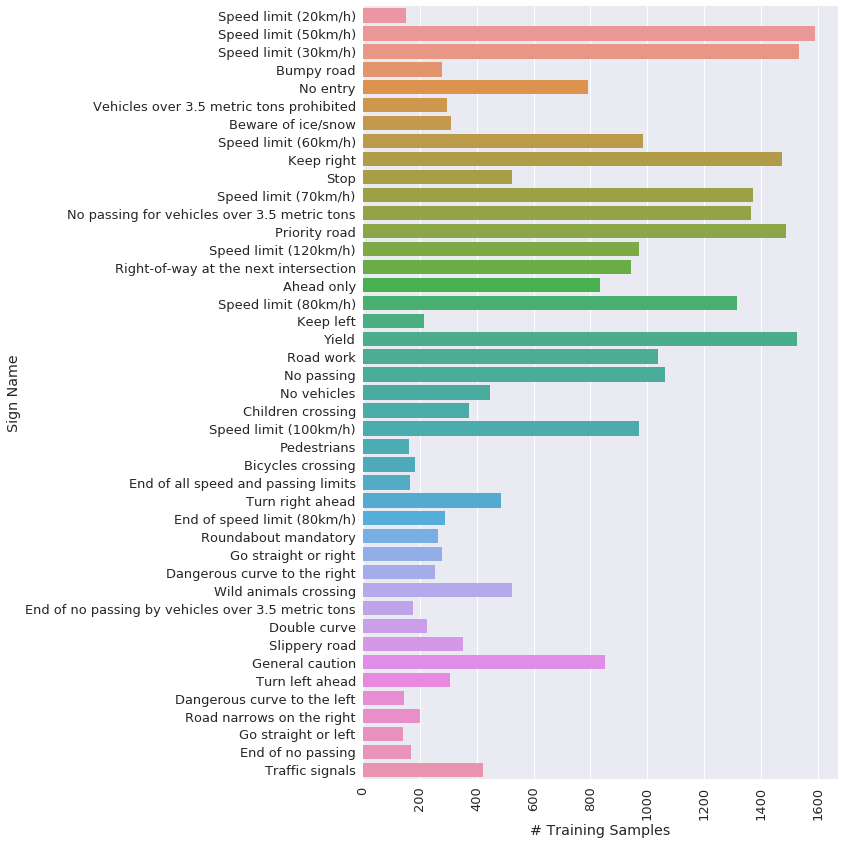

In [9]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='V')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.tight_layout()

---

## Step 2: Design and Test a Model Architecture


---

### Pre-process the Data Set (normalization, grayscale, etc.)

In [10]:
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_in, cv2.COLOR_RGB2YUV)

    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
    
    return img_out[:,:,0]


In [11]:
# Transform all images and augment training data
X_train_transf = list()
y_train_transf = list()
X_test_transf = list()
X_valid_transf = list()
for ii in range(len(X_train)):
    img = X_train[ii]
    label = y_train[ii]
    
    imgout = transform_img(img)
    imgout.shape = imgout.shape + (1,)
    X_train_transf.append(imgout)
    y_train_transf.append(label)

for ii in range(len(X_valid)):
    img = X_valid[ii]
    img = transform_img(img)
    img.shape = img.shape + (1,)
    X_valid_transf.append(img)

for ii in range(len(X_test)):
    img = X_test[ii]
    img = transform_img(img)
    img.shape = img.shape + (1,)
    X_test_transf.append(img)

---

### Model Architecture

In [12]:
import tensorflow as tf

In [13]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    """
    Implement classic lenet architecture in tensorflow
    """
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = (batch_size)x32x32x1. Output = (batch_size)x28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = (batch_size)x28x28x6. Output = (batch_size)x14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = (batch_size)x10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = (batch_size)x10x10x16. Output = (batch_size)x5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SFlatten. Input = (batch_size)x5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)
    
    dr1 = tf.nn.dropout(fc1, keep_prob) 
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dr1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    
    dr2 = tf.nn.dropout(fc2, keep_prob) 
    
    #  Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dr2, fc3_W) + fc3_b
    
    return logits

In [14]:
#Definizione dei placeholder 
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

#Restituisce un tensore (a valori binari) contenente valori tutti posti a 0 tranne uno.
one_hot_y = tf.one_hot(y, 43)

In [15]:
rate = 0.0001
#Variabili necessarie per la fase di training e di testing

logits = LeNet(x)
#softmax_cross_entropy_with_logits(_sentinel, labels, logits, dim, name)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def predict(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    predicted_proba = list()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        predicted_proba.extend( sess.run(predict_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
        
        
    return predicted_proba

Training, Validation and Testing Phases.

In [21]:
#Do some logging
import logging, datetime
logger = logging.getLogger()

def setup_file_logger(log_file):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)

def log(message):
    #outputs to Jupyter console
    print('{} {}'.format(datetime.datetime.now(), message))
    #outputs to file
    logger.info(message)

setup_file_logger('training.log')

---

### Train, Validate and Test the Model

In [23]:
from sklearn.utils import shuffle
from time import time

X_train = X_train_transf
X_valid = X_valid_transf
X_test = X_test_transf
y_train = y_train_transf

#EPOCHS = 150
EPOCHS = 50
BATCH_SIZE = 128
dropout = .3

errors = list()

saver = tf.train.Saver()
start = time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    log("Training... dropout = {} , batch_size = {} , learning rate = {}".format(dropout, BATCH_SIZE, rate))
    print()
    for i in range(EPOCHS):
        
        try:
            X_train, y_train = shuffle(X_train, y_train)
#             print("Before Train %d sec"%(time() - start))
            
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})
            
#             print("After Train %d sec"%(time() - start))
            
            validation_accuracy = evaluate(X_valid, y_valid)
            training_accuracy = evaluate(X_train, y_train)
            
            errors.append((training_accuracy,validation_accuracy))
            log("EPOCH %d - %d sec ..."%(i+1, time() - start))
            log("Training error = {:.3f} Validation error = {:.3f}".format(1- training_accuracy , 1- validation_accuracy))
            
            print()
            
#             print("After error computation %d sec"%(time() - start))
            if i > 5 and i % 3 == 0:
                saver.save(sess, './models/lenet')
                print("Model saved %d sec"%(time() - start))
        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate(X_test,y_test)))   
            break
            
    saver.save(sess, './models/lenet')

2017-12-29 09:51:17.524527 Training... dropout = 0.3 , batch_size = 128 , learning rate = 0.0001

2017-12-29 09:51:20.305564 EPOCH 1 - 2 sec ...
2017-12-29 09:51:20.306108 Training error = 0.952 Validation error = 0.950

2017-12-29 09:51:23.035267 EPOCH 2 - 5 sec ...
2017-12-29 09:51:23.035791 Training error = 0.926 Validation error = 0.927

2017-12-29 09:51:25.790193 EPOCH 3 - 8 sec ...
2017-12-29 09:51:25.790657 Training error = 0.886 Validation error = 0.890

2017-12-29 09:51:28.695672 EPOCH 4 - 11 sec ...
2017-12-29 09:51:28.696092 Training error = 0.845 Validation error = 0.848

2017-12-29 09:51:31.465358 EPOCH 5 - 13 sec ...
2017-12-29 09:51:31.465938 Training error = 0.794 Validation error = 0.796

2017-12-29 09:51:34.202710 EPOCH 6 - 16 sec ...
2017-12-29 09:51:34.203125 Training error = 0.758 Validation error = 0.753

2017-12-29 09:51:36.961607 EPOCH 7 - 19 sec ...
2017-12-29 09:51:36.962042 Training error = 0.720 Validation error = 0.716

Model saved 19 sec
2017-12-29 09:51:3

In [24]:
#Printing accuracy of the model on Training, validation and Testing set.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    print('Accuracy Model On Training Images: {:.2f}'.format(evaluate(X_train, y_train)))
    print('Accuracy Model On Validation Images: {:.2f}'.format(evaluate(X_valid, y_valid))) 
    print('Accuracy Model On Test Images: {:.2f}'.format(evaluate(X_test, y_test))) 

INFO:tensorflow:Restoring parameters from ./models/lenet
Accuracy Model On Training Images: 0.89
Accuracy Model On Validation Images: 0.87
Accuracy Model On Test Images: 0.87


Next work --> Text model on new images